In [1]:
# general tools
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.config.run_functions_eagerly(True)

# from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
# from keras_unet_collection import layer_utils as k_layers
# from keras_unet_collection.activations import GELU

2022-09-16 11:36:14.144098: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu
import convnext_keras as ck

from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline



In [4]:
from importlib import reload
reload(ck)

<module 'convnext_keras' from '/glade/u/home/ksha/NCAR/libs/convnext_keras.py'>

In [6]:
filename_neg_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/TRAIN*neg_neg_neg*.npy"))
filename_pos_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/TRAIN*pos*.npy"))

In [7]:
filename_neg_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*neg_neg_neg*.npy"))
filename_pos_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*pos*.npy"))

In [12]:
filename_valid = filename_neg_valid[::20] + filename_pos_valid[::20]

In [13]:
len(filename_valid)

4286

In [42]:
ind_pick_from_batch = [2, 11, 17, 18]

L_vars = 4
L_vars_h = 4
L_vars_ori = 19

In [43]:
L_valid = len(filename_valid)

TEST_input = np.empty((L_valid, 128, 128, L_vars))
TEST_target = np.ones(L_valid)

for i, name in enumerate(filename_valid):
    
    data = np.load(name)
    data_c = data[..., 0:L_vars_ori]
    #data_p = data[..., L_vars_ori:(2*L_vars_ori)]
    #data_a = data[..., (2*L_vars_ori):(3*L_vars_ori)]
    
    for j, c in enumerate(ind_pick_from_batch):
        TEST_input[i, ..., j] = data_c[..., c]
        #TEST_input[i, ..., L_vars_h+j] = data_a[..., c] - data_p[..., c]
    
    if 'pos' in name:
        TEST_target[i] = 1.0
    else:
        TEST_target[i] = 0.0

In [44]:
prob_base = np.sum(TEST_target) / len(TEST_target)

In [45]:
prob_base

0.009566028931404572

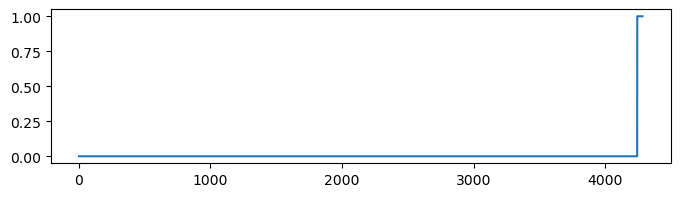

In [46]:
plt.figure(figsize=(8, 2))
plt.plot(TEST_target)

**ConvNext**

In [47]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import Model

  
class LayerScale(layers.Layer):
    """Layer scale module.
    References:
      - https://arxiv.org/abs/2103.17239
    Args:
      init_values (float): Initial value for layer scale. Should be within
        [0, 1].
      projection_dim (int): Projection dimensionality.
    Returns:
      Tensor multiplied to the scale.
    """

    def __init__(self, init_values, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = tf.Variable(
            self.init_values * tf.ones((self.projection_dim,))
        )

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "init_values": self.init_values,
                "projection_dim": self.projection_dim,
            }
        )
        return config
    


In [119]:
depths=[3, 3, 27, 3]
projection_dims=[96, 192, 384, 768]
drop_path_rate=0.0
layer_scale_init_value=0.5
model_name='test'
input_shape=(128, 128, 4)
classes=1

IN = layers.Input(shape=input_shape)
X = IN

num_convnext_blocks = 4

# ----- convnext block 0 ----- #

X = layers.Conv2D(projection_dims[0], kernel_size=4, strides=4, name="{}_down0".format(model_name))(X)
X = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_norm".format(model_name))(X)

for j in range(depths[0]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[0], kernel_size=7, padding="same",
                               groups=projection_dims[0], name="{}_down0_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[0], name="{}_down0_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down0_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[0], name="{}_down0_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[0], name="{}_down0_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext


# ----- convnext block 1 ----- #

X = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_norm".format(model_name))(X)
X = layers.Conv2D(projection_dims[1], kernel_size=2, strides=2, name="{}_down1".format(model_name))(X)

for j in range(depths[1]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[1], kernel_size=7, padding="same",
                               groups=projection_dims[1], name="{}_down1_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[1], name="{}_down1_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down1_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[1], name="{}_down1_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[1], name="{}_down1_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext

# ----- convnext block 2 ----- #

X = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_norm".format(model_name))(X)
X = layers.Conv2D(projection_dims[2], kernel_size=2, strides=2, name="{}_down2".format(model_name))(X)

for j in range(depths[2]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[2], kernel_size=7, padding="same",
                               groups=projection_dims[2], name="{}_down2_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[2], name="{}_down2_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down2_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[2], name="{}_down2_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[2], name="{}_down2_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext

# ----- convnext block 3 ----- #

X = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_norm".format(model_name))(X)
X = layers.Conv2D(projection_dims[3], kernel_size=2, strides=1, name="{}_down3".format(model_name))(X)

for j in range(depths[3]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[3], kernel_size=7, padding="same",
                               groups=projection_dims[3], name="{}_down3_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[3], name="{}_down3_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down3_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[3], name="{}_down3_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[3], name="{}_down3_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext

OUT = X

OUT = layers.GlobalMaxPooling2D(name="{}_head_pool".format(model_name))(OUT)
OUT = layers.LayerNormalization(epsilon=1e-6, name="{}_head_pool_norm".format(model_name))(OUT)

OUT = layers.Dense(256, name="{}_head_dense1".format(model_name))(OUT)
OUT = layers.Activation("gelu", name="{}_head_dense1_gelu".format(model_name))(OUT)
OUT = layers.LayerNormalization(epsilon=1e-6, name="{}_head_dense1_norm".format(model_name))(OUT)

OUT = layers.Dense(64, name="{}_head_dense2".format(model_name))(OUT)
OUT = layers.Activation("gelu", name="{}_head_dense2_gelu".format(model_name))(OUT)
OUT = layers.LayerNormalization(epsilon=1e-6, name="{}_head_dense2_norm".format(model_name))(OUT)

OUT = layers.Dense(1, name="{}_head_out".format(model_name))(OUT)

model = Model(inputs=IN, outputs=OUT, name=model_name)

In [120]:
from sklearn.metrics import brier_score_loss

def verif_metric(VALID_target, Y_pred, thres=0.5):

    tn, fp, fn, tp = confusion_matrix(VALID_target.ravel(), Y_pred.ravel()>thres).ravel()

    CSI = tp/(tp+fn+fp)
    CSI_metric = 1 - CSI

    fpr, tpr, thresholds = roc_curve(VALID_target.ravel(), Y_pred.ravel())
    AUC = auc(fpr, tpr)
    AUC_metric = 1 - AUC
    
    freq = (tp+fp)/(tp+fn)
    freq_metric = np.abs(freq-1.0)
    
    BS = brier_score_loss(VALID_target.ravel(), Y_pred.ravel())
    
    print('{} {} {} {}'.format(CSI, AUC, freq, BS))
    metric = AUC_metric + 2*BS


    return metric


# def verif_metric(VALID_target, Y_pred, prob_base):
#     BS = np.mean((Y_pred.ravel()-VALID_target.ravel())**2)
#     BSS = 1-(BS/prob_base)
#     print('BS = {}; BSS = {}'.format(BS, BSS))
#     return BS/prob_base

In [121]:
tol = 0
min_del = 0
max_tol = 500 # early stopping with patience

epochs = 500
L_train = 64
batch_size = 100

batch_size_half = 50

valid_size = 1

In [122]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'NEW_D'

model_name = '{}_pp4_tune4'.format(key)
model_path = temp_dir+model_name

W_new = model.get_weights()
W_old = k_utils.dummy_loader(temp_dir+'NEW_D_pp4_tune3')

for l in range(len(W_new)):
    if W_new[l].shape == W_old[l].shape:
        W_new[l] = W_old[l]

model.set_weights(W_new)


In [123]:
model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.SGD(lr=1e-6))

In [124]:
X_batch = np.empty((batch_size, 128, 128, L_vars))
Y_batch = np.empty((batch_size, 1))
X_batch[...] = np.nan
Y_batch[...] = np.nan

In [125]:
Y_pred = model.predict([TEST_input,])

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


In [126]:
Y_pred[Y_pred<0] = 0
Y_pred[Y_pred>1] = 1
record_temp = verif_metric(TEST_target, Y_pred)
record = record_temp
print("Initial record: {}".format(record))

0.07407407407407407 0.7940015513229338 1.1219512195121952 0.020486844810598176
Initial record: 0.24697213829826253


In [127]:
#verif_metric(TEST_target, Y_pred, thres=0.5)

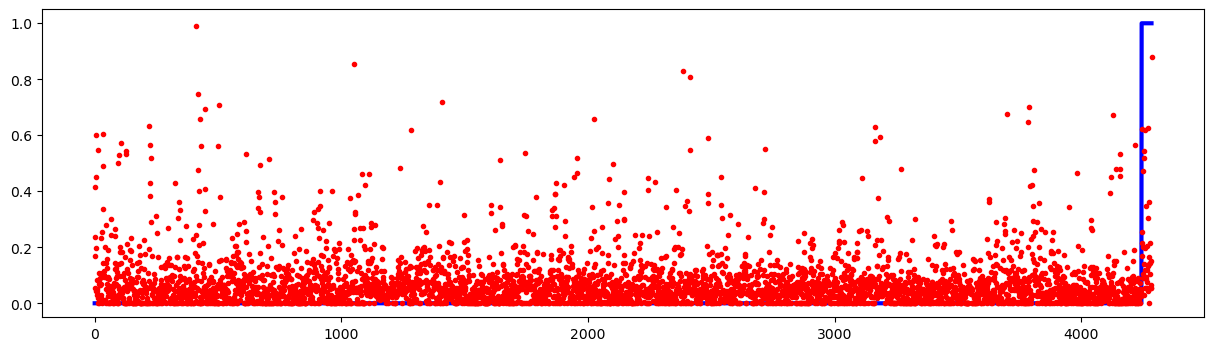

In [128]:
plt.figure(figsize=(15, 4))
plt.plot(TEST_target[:], 'b-', lw=3.0)
plt.plot(Y_pred[:], 'r.')
#plt.plot(Y_pred>0.5)

In [129]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [131]:
# ========== Training loop ========== #

N_aug = int(np.random.uniform(17, 41))
N_storm = 100 - N_aug

L_storm = len(filename_neg_train)
L_aug = len(filename_pos_train)

for i in range(epochs):
    
    shuffle(filename_neg_train)
    shuffle(filename_pos_train)
    
    #print('epoch = {}'.format(i))
    start_time = time.time()
    
    # loop of batch
    for j in range(L_train):
        
        ind_storm = du.shuffle_ind(L_storm)
        ind_aug = du.shuffle_ind(L_aug)
        
        file_pick_storm = []
        for ind_temp in ind_storm[:N_storm]:
            file_pick_storm.append(filename_neg_train[ind_temp])

        file_pick_aug = []
        for ind_temp in ind_aug[:N_aug]:
            file_pick_aug.append(filename_pos_train[ind_temp])
        
        file_pick = file_pick_storm + file_pick_aug
        
        if len(file_pick) != 100:
            sregwet
        
        for k in range(batch_size):
            
            data = np.load(file_pick[k])
            
            data = np.load(file_pick[k])
            data_c = data[..., 0:L_vars_ori]
            #data_p = data[..., L_vars_ori:(2*L_vars_ori)]
            #data_a = data[..., (2*L_vars_ori):(3*L_vars_ori)]

            for m, c in enumerate(ind_pick_from_batch):
                X_batch[k, ..., m] = data_c[..., c]
                #X_batch[k, ..., L_vars_h+m] = data_a[..., c] - data_p[..., c]
            
            # #for c, v in enumerate(ind_pick_from_batch):
            # X_batch[k, ...] = data
            
            if 'pos' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.65, 0.95)
            elif 'neg_neg_neg' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.01, 0.05)
            else:
                werhgaer
                
        #Y_batch_cate = tf.keras.utils.to_categorical(Y_batch)
        
        # # add noise within sparse inputs
        # for v in flag_sparse:
        #     X_batch[..., v] += np.random.uniform(0, 0.01, size=(batch_size, 128, 128))

        # shuffle indices
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([TEST_input,])
    Y_pred[Y_pred<0] = 0
    Y_pred[Y_pred>1] = 1
    #Y_pred = Y_pred[:, -1]
    
    record_temp = verif_metric(TEST_target, Y_pred)
    
    # if i % 10 == 0:
    #     model.save(model_path_backup)
    
    if (record - record_temp > min_del) and (np.max(Y_pred) > 0.6):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.07142857142857142 0.7950587491740642 1.1951219512195121 0.02158111794637464
Validation loss 0.24810348671868512 NOT improved


ValueError: Object arrays cannot be loaded when allow_pickle=False

In [76]:
model.save(model_path)

INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/NEW_D_pp4_tune3/assets


In [ ]:
import tf.keras.backend as K

In [ ]:
def custom_loss(y_true, y_pred):
            
    y_pred_neg = y_pred[y_true == 0]
    y_pred_pos = y_pred[y_true == 1]
    
    loss = 0.1*K.mean(y_pred_neg) + K.mean(K.abs(y_pred_pos-1))
        
    return loss